# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Phakhanan Rataphaibul

**Student ID:**    33654735

## Part 1:  Text Classification

### This part focuses on building a text classifier that predicts the class 'ComputationalLinguistics' using the 'Abstract' and 'Title' fields with statistical and RNN methods.

In [ ]:
# Please uncomment if any of the libraries are not yet installed

#!pip3 install torch
#pip3 install torchtext
#!pip3 install pyldavis
#!pip3 install scikit-learn

In [ ]:
# Importing necessary libraries and modules

%matplotlib inline

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import nltk

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext import data
import torch.optim as optim
import time
from gensim.models import Phrases


from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.exceptions import NotFittedError
import matplotlib.pyplot as plt

In [ ]:
# Download necessary resources for NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Define file paths for the training, testing, and dev datasets
train_path = 'train_set.csv'
test_path = 'dev_set.csv'
validation_path = 'test_set.csv'

In [ ]:
# Read the CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
validation_df = pd.read_csv(validation_path)

In [ ]:
# Renaming the column 'ComputationalLinguistics' to 'label' for consistency across dataframes
train_df.rename(columns = {'ComputationalLinguistics': 'label'}, inplace = True)
test_df.rename(columns = {'ComputationalLinguistics': 'label'}, inplace = True)
validation_df.rename(columns = {'ComputationalLinguistics': 'label'}, inplace = True)

# Creating dataframes for abstract and label
full_abstract_train_df = train_df[['abstract', 'label']] # Full dataset
part_abstract_train_df = train_df[['abstract', 'label']].iloc[:1000] # First 1000 rows (partial)
test_abstract_df = test_df[['abstract', 'label']]
validation_abstract_df = validation_df[['abstract', 'label']]

# Creating dataframes for title and label
full_title_train_df = train_df[['title', 'label']] # Full dataset
part_title_train_df = train_df[['title', 'label']].iloc[:1000] # First 1000 rows (partial)
test_title_df = test_df[['title', 'label']]
validation_title_df = validation_df[['title', 'label']]

In [ ]:
# Define a custom tokenizer class for tokenization and stemming
class StemTokenizer:
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

In [ ]:
# Convert dataframes to list for model training

full_abstract_trainDocs = full_abstract_train_df.abstract.tolist() + test_abstract_df.abstract.tolist()
full_abstract_trainLabels = full_abstract_train_df.label.tolist() + test_abstract_df.label.tolist()

part_abstract_trainDocs = part_abstract_train_df.abstract.tolist() + test_abstract_df.abstract.tolist()
part_abstract_trainLabels = part_abstract_train_df.label.tolist() + test_abstract_df.label.tolist()

full_title_trainDocs = full_title_train_df.title.tolist() + test_title_df.title.tolist()
full_title_trainLabels = full_title_train_df.label.tolist() + test_title_df.label.tolist()

part_title_trainDocs = part_title_train_df.title.tolist() + test_title_df.title.tolist()
part_title_trainLabels = part_title_train_df.label.tolist() + test_title_df.label.tolist()

In [ ]:
# Initializing vectorizers for full dataset using abstract column
abstract_vectorizer_full = TfidfVectorizer(analyzer='word',
                                           input='content',
                                           lowercase=True,
                                           token_pattern='(?u)\\b\\w\\w+\\b',
                                           min_df=3, ngram_range=(1,2),
                                           tokenizer=StemTokenizer())

# Initializing vectorizers for the first 1000 rows of the dataset using abstract column
abstract_vectorizer_part = TfidfVectorizer(analyzer='word',
                                           input='content',
                                           lowercase=True,
                                           token_pattern='(?u)\\b\\w\\w+\\b',
                                           min_df=3, ngram_range=(1,2),
                                           tokenizer=StemTokenizer())

# Initializing vectorizers for full dataset using title column
title_vectorizer_full = TfidfVectorizer(analyzer='word',
                                        input='content',
                                        lowercase=True,
                                        token_pattern='(?u)\\b\\w\\w+\\b',
                                        min_df=3, ngram_range=(1,2),
                                        tokenizer=StemTokenizer())

# Initializing vectorizers for the first 1000 rows of the dataset using title column
title_vectorizer_part = TfidfVectorizer(analyzer='word',
                                        input='content',
                                        lowercase=True, token_pattern='(?u)\\b\\w\\w+\\b',
                                        min_df=3,
                                        ngram_range=(1,2),
                                        tokenizer=StemTokenizer())

In [ ]:
# Transforming full abstract training data using TF-IDF vectorizers
x_full_abstract_train = abstract_vectorizer_full.fit_transform(full_abstract_trainDocs)
# Training labels for full abstract
y_full_abstract_train = np.asarray(full_abstract_trainLabels)

# Transforming partial abstract training data using TF-IDF vectorizers
x_part_abstract_train = abstract_vectorizer_part.fit_transform(part_abstract_trainDocs)
# Training labels for partial abstract
y_part_abstract_train = np.asarray(part_abstract_trainLabels)

# Transforming full title training data using TF-IDF vectorizers
x_full_title_train = title_vectorizer_full.fit_transform(full_title_trainDocs)
# Training labels for full abstract
y_full_title_train = np.asarray(full_title_trainLabels)

# Transforming partial title training data using TF-IDF vectorizers
x_part_title_train = title_vectorizer_part.fit_transform(part_title_trainDocs)
# Training labels for partial title
y_part_title_train = np.asarray(part_title_trainLabels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Convert dataframes to list for model testing
abstract_testDocs = validation_abstract_df.abstract.tolist()
abstract_testLabels = validation_abstract_df.label.tolist()
title_testDocs = validation_title_df.title.tolist()
title_testLabels = validation_title_df.label.tolist()

# Transforming full abstract testing data using TF-IDF vectorizers
x_full_abstract_test = abstract_vectorizer_full.transform(abstract_testDocs)
# Testing labels for full abstract
y_full_abstract_test = np.asarray(abstract_testLabels)

# Transforming partial abstract testing data using TF-IDF vectorizers
x_part_abstract_test = abstract_vectorizer_part.transform(abstract_testDocs)
# Testing labels for partial abstract
y_part_abstract_test = np.asarray(abstract_testLabels)

# Transforming full title testing data using TF-IDF vectorizers
x_full_title_test = title_vectorizer_full.transform(title_testDocs)
# Testing labels for full title
y_full_title_test = np.asarray(title_testLabels)

# Transforming partial title testing data using TF-IDF vectorizers
x_part_title_test = title_vectorizer_part.transform(title_testDocs)
# Testing labels for partial title
y_part_title_test = np.asarray(title_testLabels)

### Part 1A: Statistical Method

###Train the models for each configuration using LinearSVC model

In [ ]:
#  Define function for training a statistical model using the Linear Support Vector Classifier (LinearSVC)
def statistical_model_training(x_train, y_train):
    model = LinearSVC(max_iter = 1000)
    model.fit(x_train, y_train)
    return model

In [ ]:
# Define a dictionary mapping dataset descriptions to their respective training and testing sets
dataset_mappings = {
    "First 1000 Titles Dataset": (x_part_title_train, y_part_title_train, x_part_title_test, y_part_title_test),
    "First 1000 Abstracts Dataset": (x_part_abstract_train, y_part_abstract_train, x_part_abstract_test, y_part_abstract_test),
    "Full Titles Dataset": (x_full_title_train, y_full_title_train, x_full_title_test, y_full_title_test),
    "Full Abstracts Dataset": (x_full_abstract_train, y_full_abstract_train, x_full_abstract_test, y_full_abstract_test)
}

# Initialize an empty dictionary to store trained models
trained_models = {}

# Loop through each item in the dataset mappings to train the model
for description, (X_train, y_train, _, _) in dataset_mappings.items():
    print(f"Training LinearSVC model for {description}")
    trained_models[description] = statistical_model_training(X_train, y_train)

Training LinearSVC model for First 1000 Titles Dataset
Training LinearSVC model for First 1000 Abstracts Dataset
Training LinearSVC model for Full Titles Dataset
Training LinearSVC model for Full Abstracts Dataset


### Part 1B: RNN Method

### Train the models for each configuration using RNN method

In [ ]:
# Initialize a basic English tokenizer
tokenizer = get_tokenizer('basic_english')

# Define a generator function to yield a list of tokens for each text in the dataset
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Define a function to convert dataframe column to a list of tuples containing labels and text
def df_to_list(df, field):
    data = []
    for index, row in df.iterrows():
      text = row[field]
      label = row['label']
      data.append((int(label), text.strip()))
    return data

In [ ]:
# Convert dataframe columns to lists of tuples for RNN training
# For full abstract training data
rnn_full_abstract_train = df_to_list(full_abstract_train_df, 'abstract')
# For partial abstract training data
rnn_part_abstract_train = df_to_list(part_abstract_train_df, 'abstract')
# For abstract testing data
rnn_test_abstract = df_to_list(test_abstract_df, 'abstract')
# For abstract validation data
rnn_validation_abstract = df_to_list(validation_abstract_df, 'abstract')

# For full title training data
rnn_full_title_train = df_to_list(full_title_train_df, 'title')
# For partial title training data
rnn_part_title_train = df_to_list(part_title_train_df, 'title')
# For title testing data
rnn_test_title = df_to_list(test_title_df, 'title')
# For title validation data
rnn_validation_title = df_to_list(validation_title_df, 'title')

In [ ]:
 # Initialize a stem tokenizer for tokenization and stemming
tokenizer = StemTokenizer()

# Define function to build vocabulary from text data
def build_vocab(df):
  vocab = build_vocab_from_iterator(yield_tokens(df), specials = ["<unk>"])
  vocab.set_default_index(vocab["<unk>"])
  return vocab

# Define function for data processing pipeline
def text_pipeline(vocab, x):
    return vocab(tokenizer(x))

# Define function for collating a batch of labeled text data for input into the model
def collate_batch(batch, vocab):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(vocab, _text), dtype=torch.int64)
        text_list.append(processed_text)
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=vocab["<unk>"])

In [ ]:
# Build vocab for all training datasets
vocab_rnn_full_abstract = build_vocab(rnn_full_abstract_train)
vocab_rnn_part_abstract = build_vocab(rnn_part_abstract_train)
vocab_rnn_full_title = build_vocab(rnn_full_title_train)
vocab_rnn_part_title = build_vocab(rnn_part_title_train)

In [ ]:
# Define function to print information about the vocabulary and label
def print_vocabulary_and_labels(description, vocab, data):
    # Print first 10 words from the vocabulary
    print(f"{description} Vocabulary Sample:", list(vocab.get_itos())[:10])

    # Extract unique labels from the training data
    unique_labels = set(label for label, _ in data)
    print(f"{description} Unique Labels:", unique_labels)

    # Count total vocabulary and label size
    vocab_size = len(vocab)
    label_size = len(unique_labels)
    print(f"{description} Unique tokens in TEXT vocabulary: {vocab_size}")
    print(f"{description} Unique tokens in LABEL vocabulary: {label_size}\n")
    return [vocab_size, label_size]

In [ ]:
# Print vocabulary and label information for different datasets
full_abstract_vocab_sample = print_vocabulary_and_labels("Full Abstract", vocab_rnn_full_abstract, rnn_full_abstract_train)
part_abstract_vocab_sample = print_vocabulary_and_labels("Part Abstract", vocab_rnn_part_abstract, rnn_part_abstract_train)
full_title_vocab_sample = print_vocabulary_and_labels("Full Title", vocab_rnn_full_title, rnn_full_title_train)
part_title_vocab_sample = print_vocabulary_and_labels("Part Title", vocab_rnn_part_title, rnn_part_title_train)

Full Abstract Vocabulary Sample: ['<unk>', 'the', ',', '.', 'of', 'and', 'to', 'a', 'in', 'we']
Full Abstract Unique Labels: {0, 1}
Full Abstract Unique tokens in TEXT vocabulary: 263263
Full Abstract Unique tokens in LABEL vocabulary: 2

Part Abstract Vocabulary Sample: ['<unk>', 'the', ',', '.', 'of', 'and', 'to', 'a', 'in', 'we']
Part Abstract Unique Labels: {0, 1}
Part Abstract Unique tokens in TEXT vocabulary: 9366
Part Abstract Unique tokens in LABEL vocabulary: 2

Full Title Vocabulary Sample: ['<unk>', 'for', ':', 'and', 'of', 'a', 'with', 'in', 'learn', 'model']
Full Title Unique Labels: {0, 1}
Full Title Unique tokens in TEXT vocabulary: 67498
Full Title Unique tokens in LABEL vocabulary: 2

Part Title Vocabulary Sample: ['<unk>', 'for', ':', 'and', 'of', 'a', 'in', 'learn', 'with', 'model']
Part Title Unique Labels: {0, 1}
Part Title Unique tokens in TEXT vocabulary: 2554
Part Title Unique tokens in LABEL vocabulary: 2



In [ ]:
from torch.utils.data import Dataset

# Define dataset class for text data
class TextDataset(Dataset):
    # Initialize the dataset object
    def __init__(self, data):
        self.data = data

    # Return the number of items in the dataset
    def __len__(self):
        return len(self.data)

    # Retrieve a specific item from the dataset by index
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
 # Create instances of TextDataset for different datasets
# For full abstract training data
train_full_abstract_dataset = TextDataset(rnn_full_abstract_train)
# For partial abstract training data
train_part_abstract_dataset = TextDataset(rnn_part_abstract_train)
# For abstract testing data
test_abstract_dataset = TextDataset(rnn_test_abstract)
# For abstract validation data
validation_abstract_dataset = TextDataset(rnn_validation_abstract)

# For full title training data
train_full_title_dataset = TextDataset(rnn_full_title_train)
# For partial title training data
train_part_title_dataset = TextDataset(rnn_part_title_train)
# For title testing data
test_title_dataset = TextDataset(rnn_test_title)
# For title validation data
validation_title_dataset = TextDataset(rnn_validation_title)

In [ ]:
# Create DataLoader instances for different datasets
# For full abstract training data
train_full_abstract_dataloader = DataLoader(train_full_abstract_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_full_abstract))
# For partial abstract training data
train_part_abstract_dataloader = DataLoader(train_part_abstract_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_part_abstract))
# For full abstract testing data
test_full_abstract_dataloader = DataLoader(test_abstract_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_full_abstract))
# For partial abstract testing data
test_part_abstract_dataloader = DataLoader(test_abstract_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_part_abstract))
# For full abstract validation data
validation_full_abstract_dataloader = DataLoader(validation_abstract_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_full_abstract))
# For partial abstract validation data
validation_part_abstract_dataloader = DataLoader(validation_abstract_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_part_abstract))

# For full title training data
train_full_title_dataloader = DataLoader(train_full_title_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_full_title))
# For partial title training data
train_part_title_dataloader = DataLoader(train_part_title_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_part_title))
# For full title testing data
test_full_title_dataloader = DataLoader(test_title_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_full_title))
# For partial title testing data
test_part_title_dataloader = DataLoader(test_title_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_part_title))
# For full title validation data
validation_full_title_dataloader = DataLoader(validation_title_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_full_title))
# For partial title validation data
validation_part_title_dataloader = DataLoader(validation_title_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_batch(batch, vocab_rnn_part_title))

In [ ]:
 # Define function to print the first batch of data from a DataLoader
def print_first_batch(dataloader, description):
    try:
        first_batch = next(iter(dataloader))
        print(f"First batch from {description} DataLoader:")
        print(f"Features (text data): {first_batch[0]}")
        print(f"Labels: {first_batch[1]}\n")
    except StopIteration:
        print(f"The {description} DataLoader is empty.\n")
    except Exception as e:
        print(f"An error occurred while accessing the {description} DataLoader: {str(e)}\n")

In [ ]:
# Print the first batch of data from a DataLoader
print_first_batch(train_full_abstract_dataloader, 'full abstract')
print_first_batch(train_part_abstract_dataloader, 'part abstract')
print_first_batch(train_full_title_dataloader, 'full title')
print_first_batch(train_part_title_dataloader, 'part title')

First batch from full abstract DataLoader:
Features (text data): tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0])
Labels: tensor([[1718,  387,    1,  ...,    9,   17,    8],
        [1726,    5,  108,  ...,   96,   46,   17],
        [ 264,   89, 1397,  ...,    1,  273,   46],
        ...,
        [   0,    0,    0,  ...,    0,    0, 1856],
        [   0,    0,    0,  ...,    0,    0,  388],
        [   0,    0,    0,  ...,    0,    0,    3]])

First batch from part abstract DataLoader:
Features (text data): tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])
Labels: tensor([[  9,  17,   7,  ...,   9,  96, 316],
        [ 26,  46, 109,  ..., 256,  23,  97],
        [ 27,  84, 101,  ..., 369,  10,   7],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]])

First batc

In [ ]:
import torch.nn as nn

# Define an RNN class
class RNN(nn.Module):
    # Initializes the RNN model with the given dimensions
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    # Forward pass of the model
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))


In [ ]:
# Define function to create and initialize an RNN model for training
def rnn_train_model(vocab_size, embedding_dim = 100, hidden_dim = 256, output_dim = 1):
  INPUT_DIM = vocab_size
  EMBEDDING_DIM = embedding_dim
  HIDDEN_DIM = hidden_dim
  OUTPUT_DIM = output_dim
  model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
  return model


In [ ]:
# Initialize RNN model with the specified parameters
# For full abstract dataset
full_abstract_rnn_model = rnn_train_model(full_abstract_vocab_sample[0], 100, 256, 1)
# For partial abstract dataset
part_abstract_rnn_model = rnn_train_model(part_abstract_vocab_sample[0], 100, 256, 1)
# For full title dataset
full_title_rnn_model = rnn_train_model(full_title_vocab_sample[0], 100, 256, 1)
# For partial title dataset
part_title_rnn_model = rnn_train_model(part_title_vocab_sample[0], 100, 256, 1)


In [ ]:
# Define function to count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters for each model
print(f'The model has {count_parameters(full_abstract_rnn_model):,} trainable parameters')
print(f'The model has {count_parameters(part_abstract_rnn_model):,} trainable parameters')
print(f'The model has {count_parameters(full_title_rnn_model):,} trainable parameters')
print(f'The model has {count_parameters(part_title_rnn_model):,} trainable parameters')

The model has 26,418,205 trainable parameters
The model has 1,028,505 trainable parameters
The model has 6,841,705 trainable parameters
The model has 347,305 trainable parameters


In [ ]:
# Define optimizers for training RNN models on different datasets
# For full abstract dataset
full_abstract_optimizer = optim.SGD(full_abstract_rnn_model.parameters(), lr = 1e-3)
# For partial abstract dataset
part_abstract_optimizer = optim.SGD(part_abstract_rnn_model.parameters(), lr = 1e-3)
# For full title dataset
full_title_optimizer = optim.SGD(full_title_rnn_model.parameters(), lr = 1e-3)
# For partial title dataset
part_title_optimizer = optim.SGD(part_title_rnn_model.parameters(), lr = 1e-3)

In [ ]:
# Choose device based on GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function and move it to the chosen device
criterion = nn.BCEWithLogitsLoss().to(device)

# Move each model to the device
full_abstract_rnn_model = full_abstract_rnn_model.to(device)
part_abstract_rnn_model = part_abstract_rnn_model.to(device)
full_title_rnn_model = full_title_rnn_model.to(device)
part_title_rnn_model = part_title_rnn_model.to(device)


In [ ]:
# Define function to calculate the binary accuracy of predictions
def binary_accuracy(preds, y):
    # Round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# Define function to train the model on the training data
def train(model, dataloader, optimizer, criterion, device):
    # Set the model to training mode
    model.train()
    # Initialize epoch loss and accuracy
    epoch_loss = 0
    epoch_acc = 0
    # Iterate over batches in the dataloader
    for labels, texts in dataloader:
        # Move tensors to the appropriate device
        labels = labels.to(device)
        texts = texts.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)
        # Perform backpropagation
        loss.backward()
        optimizer.step()
        # Update epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    # Return average epoch loss and accuracy
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
# Define function to evaluate the model
def evaluate(model, dataloader, criterion, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize epoch loss and accuracy
    epoch_loss = 0
    epoch_acc = 0
    # Iterate over batches in the dataloader
    with torch.no_grad():
        for labels, texts in dataloader:
            # Move tensors to the appropriate device
            labels = labels.to(device)
            texts = texts.to(device)
            # Forward pass
            predictions = model(texts).squeeze(1)
            # Calculate loss and accuracy
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)
            # Update epoch loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    # Return average epoch loss and accuracy
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
# Define function to compute the elapsed time between the start and end of an epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Define function to train the model for multiple epochs and validates it on the validation data
def train_epochs(model, train_dataloader, validation_dataloader, optimizer, criterion, model_path, device, n_epochs=5):
    # Initialize best validation loss
    best_valid_loss = float('inf')
    # Iterate over epochs
    for epoch in range(n_epochs):
        start_time = time.time()
        # Training step
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
        # Evaluation step
        valid_loss, valid_acc = evaluate(model, validation_dataloader, criterion, device)
        # Compute elapsed time
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        # Save the model if validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_path)
        # Print summary statistics for the epoch
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
# Train RNN models on each dataset for 5 epochs and print summaries
# For partial title dataset
train_epochs(part_title_rnn_model, train_part_title_dataloader, validation_part_title_dataloader, part_title_optimizer, criterion, 'part_title_RNN_model.pt', device, 5)
print('\n\n\n')
# For partial abstract dataset
train_epochs(part_abstract_rnn_model, train_part_abstract_dataloader, validation_part_abstract_dataloader, part_abstract_optimizer, criterion, 'part_abstract_RNN_model.pt', device, 5)
print('\n\n\n')
# For full title dataset
train_epochs(full_title_rnn_model, train_full_title_dataloader, validation_full_title_dataloader, full_title_optimizer, criterion, 'full_title_RNN_model.pt', device, 5)
print('\n\n\n')
# For full abstract dataset
train_epochs(full_abstract_rnn_model, train_full_abstract_dataloader, validation_full_abstract_dataloader, full_abstract_optimizer, criterion, 'full_abstract_RNN_model.pt', device, 5)
print('\n\n\n')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.661 | Train Acc: 64.36%
	 Val. Loss: 0.617 |  Val. Acc: 72.81%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.604 | Train Acc: 72.66%
	 Val. Loss: 0.590 |  Val. Acc: 73.08%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.590 | Train Acc: 72.36%
	 Val. Loss: 0.582 |  Val. Acc: 73.12%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.577 | Train Acc: 72.75%
	 Val. Loss: 0.579 |  Val. Acc: 73.13%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.577 | Train Acc: 72.95%
	 Val. Loss: 0.579 |  Val. Acc: 73.13%




Epoch: 01 | Epoch Time: 1m 21s
	Train Loss: 0.656 | Train Acc: 70.80%
	 Val. Loss: 0.625 |  Val. Acc: 72.37%
Epoch: 02 | Epoch Time: 1m 20s
	Train Loss: 0.613 | Train Acc: 71.88%
	 Val. Loss: 0.599 |  Val. Acc: 72.69%
Epoch: 03 | Epoch Time: 1m 21s
	Train Loss: 0.596 | Train Acc: 72.27%
	 Val. Loss: 0.589 |  Val. Acc: 72.82%
Epoch: 04 | Epoch Time: 1m 21s
	Train Loss: 0.598 | Train Acc: 71.39%
	 Val. Loss: 0.586 |  Val. Acc: 72.93%
Epoch: 05 | Epoch Ti

In [ ]:
# Load the trained state dictionaries of each RNN model
# For partial title dataset
part_title_rnn_model.load_state_dict(torch.load('part_title_RNN_model.pt'))
# For partial abstract dataset
part_abstract_rnn_model.load_state_dict(torch.load('part_abstract_RNN_model.pt'))
# For full title dataset
full_title_rnn_model.load_state_dict(torch.load('full_title_RNN_model.pt'))
# For full abstract dataset
full_abstract_rnn_model.load_state_dict(torch.load('full_abstract_RNN_model.pt'))

<All keys matched successfully>

In [ ]:
# Define function to make predictions using the trained RNN model on the test data
def rnn_model_prediction(model, test_dataloader, device):
  y_predict = []
  y_test = []
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      for labels, texts in test_dataloader:
          # Move tensors to the appropriate device
          texts = texts.to(device)
          labels = labels.to(device)
          # Forward pass
          predictions = model(texts).squeeze(1)
          rounded_preds = torch.round(torch.sigmoid(predictions))
          # Move predictions to the appropriate device for further processing or storing
          y_predict.extend(rounded_preds.cpu().numpy())
          y_test.extend(labels.cpu().numpy())
  return y_predict, y_test

### Part 1C:  Results for Methods

#### Statistical Models Evaluation

In [ ]:
# Define function to evaluate the statistical models
def statistical_model_evaluation(model, x_test, y_test):
    # Make predictions using the model
    y_predict = model.predict(x_test)
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict, average = 'macro')
    precision = precision_score(y_test, y_predict, average = 'macro')
    f1score = f1_score(y_test, y_predict, average = 'macro')
    matthews = matthews_corrcoef(y_test, y_predict)
    # Print evaluation metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_predict))
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Macro Precision: {precision:.4f}')
    print(f'Macro Recall: {recall:.4f}')
    print(f'Macro F1 score: {f1score:.4f}')
    print(f'MCC: {matthews:.4f}')

In [ ]:
# Evaluating the models and display evaluation metrics
for description, (_, _, x_test, y_test) in dataset_mappings.items():
    print(f"Evaluating LinearSVC model for {description}:")
    statistical_model_evaluation(trained_models[description], x_test, y_test)

Evaluating LinearSVC model for First 1000 Titles Dataset:
Confusion Matrix:
[[13639   429]
 [  734  4272]]
Accuracy: 0.9390
Macro Precision: 0.9288
Macro Recall: 0.9114
Macro F1 score: 0.9196
MCC: 0.8401
Evaluating LinearSVC model for First 1000 Abstracts Dataset:
Confusion Matrix:
[[13868   200]
 [  345  4661]]
Accuracy: 0.9714
Macro Precision: 0.9673
Macro Recall: 0.9584
Macro F1 score: 0.9627
MCC: 0.9257
Evaluating LinearSVC model for Full Titles Dataset:
Confusion Matrix:
[[13757   311]
 [  480  4526]]
Accuracy: 0.9585
Macro Precision: 0.9510
Macro Recall: 0.9410
Macro F1 score: 0.9458
MCC: 0.8919
Evaluating LinearSVC model for Full Abstracts Dataset:
Confusion Matrix:
[[13888   180]
 [  237  4769]]
Accuracy: 0.9781
Macro Precision: 0.9734
Macro Recall: 0.9699
Macro F1 score: 0.9717
MCC: 0.9433


#### RNN Models Evaluation

In [ ]:
# Define function to evaluate the RNN models
def rnn_model_evaluation(y_predict, y_test):
  # Convert predicted and true labels to numpy arrays
  y_predict = np.asarray(y_predict)
  y_test = np.asarray(y_test)
  # Print confusion matrix
  print(confusion_matrix(y_test, y_predict))
  # Compute evaluation metrics
  recall = recall_score(y_test, y_predict,average = 'macro')
  precision = precision_score(y_test, y_predict,average = 'macro')
  f1score = f1_score(y_test, y_predict, average = 'macro')
  accuracy = accuracy_score(y_test, y_predict)
  matthews = matthews_corrcoef(y_test, y_predict)
  # Print evaluation metrics
  print('Accuracy: '+ str(accuracy))
  print('Macro Precision: '+ str(precision))
  print('Macro Recall: '+ str(recall))
  print('Macro F1 score:'+ str(f1score))
  print('MCC:'+ str(matthews))

In [ ]:
# Dictionary of models
models = {
    'part_title': part_title_rnn_model,
    'part_abstract': part_abstract_rnn_model,
    'full_title': full_title_rnn_model,
    'full_abstract': full_abstract_rnn_model
}

# Dictionary of corresponding dataloaders
dataloaders = {
    'part_title': test_part_title_dataloader,
    'part_abstract': test_part_abstract_dataloader,
    'full_title': test_full_title_dataloader,
    'full_abstract': test_full_abstract_dataloader
}

# Define function to process and evaluate each RNN model
def process_model(model_name, model, dataloader, device):
    # Generate predictions and true labels
    y_predict, y_test = rnn_model_prediction(model, dataloader, device)
    # Evaluate and print the model's performance
    print(f"{model_name.capitalize()} Model Evaluation:")
    rnn_model_evaluation(y_predict, y_test)
    print("\n")
    return y_predict, y_test

# Define function to convert logits to probabilities for each model
def logits_to_probabilities(logits):
    return torch.sigmoid(torch.tensor(logits)).numpy()

In [ ]:
# Determine the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dictionaries to store predictions and true labels for each model
predictions = {}
true_labels = {}

# Loop over each model in the dictionary of models
for model_name in models:
    # Process each model and store the returned predictions and true labels
    y_predict, y_test = process_model(model_name, models[model_name], dataloaders[model_name], device)
    predictions[model_name] = y_predict
    true_labels[model_name] = y_test

Part_title Model Evaluation:
[[13849   175]
 [ 4962    87]]
Accuracy: 0.7306663870392702
Macro Precision: 0.5341396194609213
Macro Recall: 0.5023762633888972
Macro F1 score:0.4381566402274348
MCC:0.01801385331747422


Part_abstract Model Evaluation:
[[13891   133]
 [ 5024    25]]
Accuracy: 0.7296177843024171
Macro Precision: 0.44630927165835166
Macro Recall: 0.4977338666917037
Macro F1 score:0.4265201641157159
MCC:-0.022060856542002055


Full_title Model Evaluation:
[[13995    29]
 [ 5023    26]]
Accuracy: 0.735122948670896
Macro Precision: 0.6043045344601765
Macro Recall: 0.5015408254666165
Macro F1 score:0.428645886995918
MCC:0.02535469053093121


Full_abstract Model Evaluation:
[[14018     6]
 [ 5048     1]]
Accuracy: 0.7350180883972107
Macro Precision: 0.4390463203009096
Macro Recall: 0.49988511051478735
Macro F1 score:0.4238303021869775
MCC:-0.005292612542948502




### Part 1D: Plots for Methods

#### Precision-Recall Curves for Statistical Models


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

# Define function to plot the Precision-Recall curve for statiscal models
def plot_precision_recall_curve(model, x_test, y_test, description):
    # Predict the labels and get the decision scores
    y_scores = model.decision_function(x_test)
    # Calculate precision-recall and average precision
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    # Plot the Precision-Recall curve
    plt.figure()
    plt.step(recall, precision, where='post', label=f'AP = {average_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve: {description}')
    plt.legend(loc='upper right')
    plt.show()

Evaluating First 1000 Titles Dataset: 


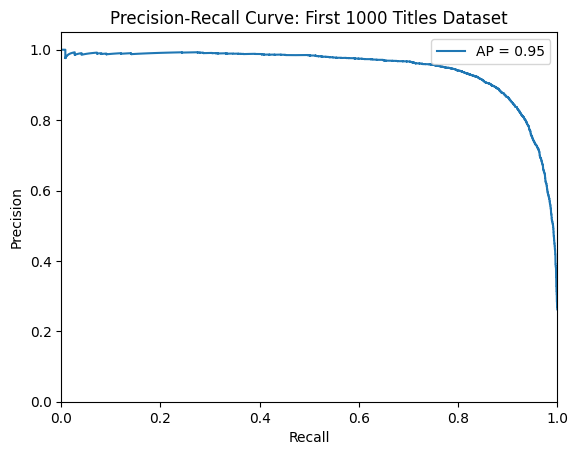

Evaluating First 1000 Abstracts Dataset: 


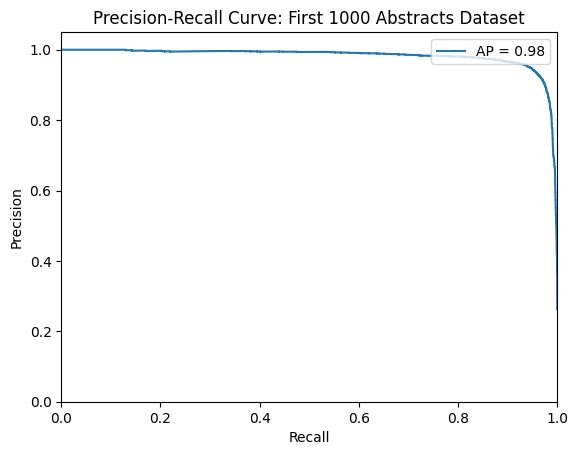

Evaluating Full Titles Dataset: 


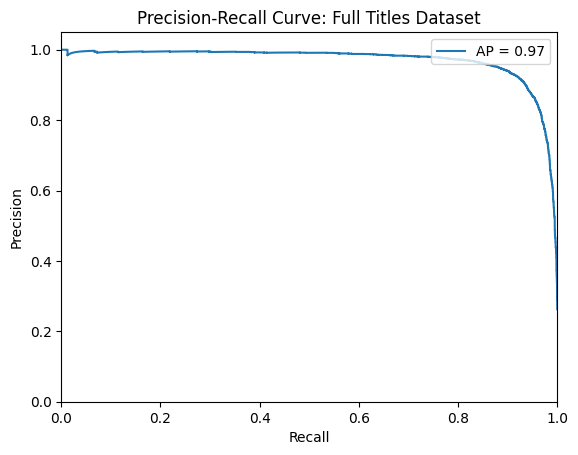

Evaluating Full Abstracts Dataset: 


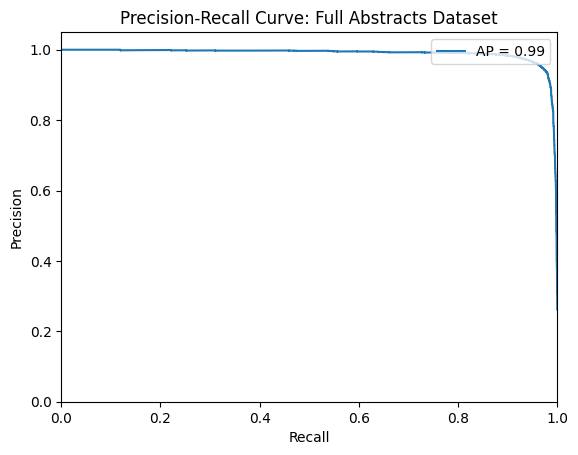

In [ ]:
# Display the plots
for description in dataset_mappings:
    x_test, y_test = dataset_mappings[description][2], dataset_mappings[description][3]
    print(f"Evaluating {description}: ")
    plot_precision_recall_curve(trained_models[description], x_test, y_test, description)

#### Precision-Recall Curves for RNN Models

In [ ]:
from sklearn.metrics import auc

# Define function to plot the Precision-Recall curve for RNN models
def rnn_model_curve(y_test, y_scores, model_name):
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    # Calculate the AUC (Area under the curve)
    pr_auc = auc(recall, precision)

    # Plot the precision-recall curve
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, marker = '.', label = f'PR curve (area = {pr_auc:.2f})')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

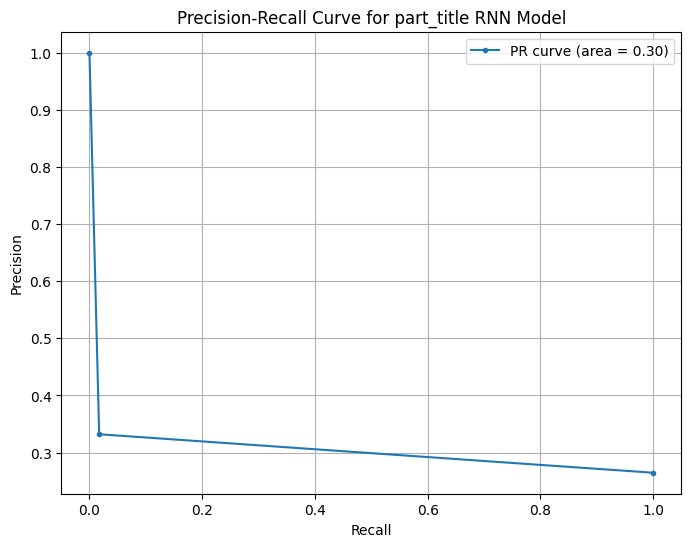

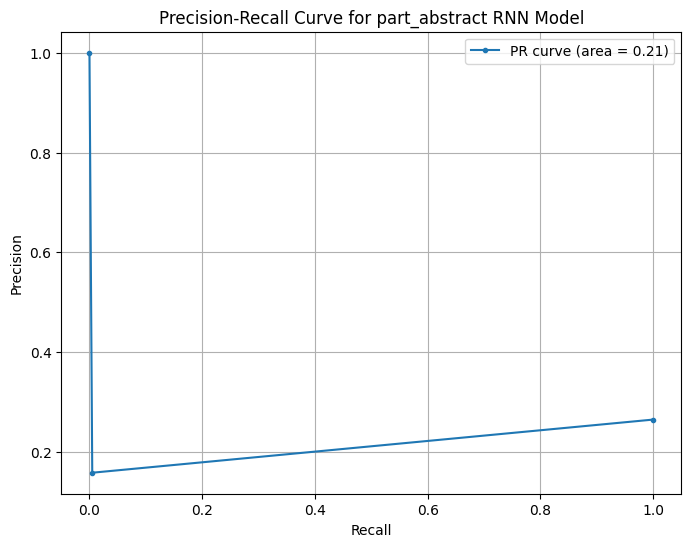

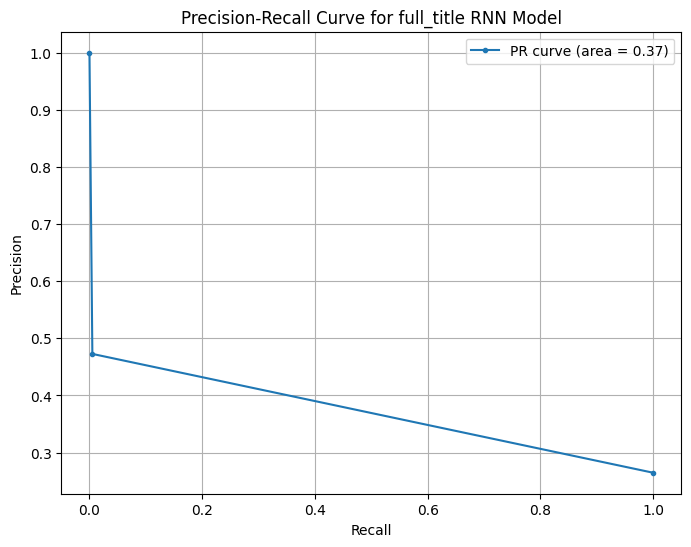

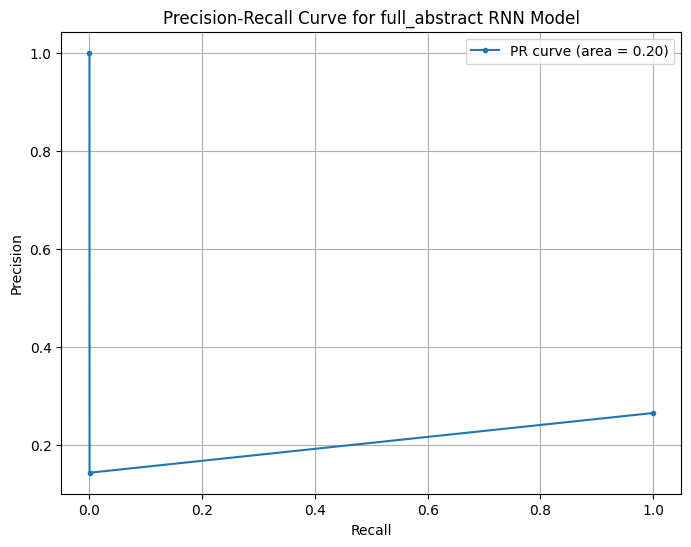

In [ ]:
# Display the plots
for model_name in predictions:
    probabilities = logits_to_probabilities(predictions[model_name])
    rnn_model_curve(true_labels[model_name], probabilities, model_name + ' RNN Model')